In [1]:
import sys
import os
sys.path.insert(0, os.path.abspath('..'))
from os.path import expanduser

%load_ext autoreload
%autoreload 2

from dotenv import load_dotenv
load_dotenv()

from google.cloud import storage
from project_config import GCP_PROJECT_NAME, DATASET_JSON_PATH

gcp_client = storage.Client(project=GCP_PROJECT_NAME)

2024-01-27 08:41:20:rastervision.pipeline.rv_config: WARNING - Root temporary directory cannot be used: /opt/data/tmp. Using root: /tmp/tmp5pwhmpky
/home/gautam/anaconda3/envs/sand-mining/lib/python3.9/site-packages/geopandas/_compat.py:124: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.3-CAPI-1.16.1). Conversions between both will be slow.
  warnings.warn(


In [2]:
import os, torch
# os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:32" #to prevent cuda out of memory error
torch.cuda.empty_cache()


#For reproducibility
torch.manual_seed(13)

In [3]:
from experiment_configs.configs import *
config = testing_config

In [4]:
from torch.utils.data import ConcatDataset
import json
from utils.rastervision_pipeline import observation_to_scene, scene_to_training_ds, scene_to_validation_ds, scene_to_inference_ds
from utils.data_management import observation_factory, characterize_dataset
import random

#set the seed
random.seed(13)

# get the current working directory
root_dir = os.getcwd()

# define the relative path to the dataset JSON file
json_rel_path = '../' + DATASET_JSON_PATH

# combine the root directory with the relative path
json_abs_path = os.path.join(root_dir, json_rel_path)

dataset_json = json.load(open(json_abs_path, 'r'))
all_observations = observation_factory(dataset_json)

#find the highest cluster id
max_cluster_id = max([observation['cluster_id'] for observation in dataset_json])


# Randomly split the data into training and validation
val_split = random.randint(0, max_cluster_id+1)

training_scenes = []
validation_scenes = []

for observation in list(all_observations)[:3]:
    if observation.cluster_id == val_split: 
        validation_scenes.append(observation_to_scene(config, observation))
    else:
        training_scenes.append(observation_to_scene(config, observation))


training_datasets = [
    scene_to_training_ds(config, scene) for scene in training_scenes #random window sampling happens here
]
validation_datasets = [
    # scene_to_validation_ds(config, scene) for scene in validation_scenes
    scene_to_inference_ds(config, scene, full_image=False, stride=int(config.tile_size/2)) for scene in validation_scenes # better performance with this
]

train_dataset_merged = ConcatDataset(training_datasets)
# val_dataset_merged = ConcatDataset(validation_datasets)
val_dataset_merged = train_dataset_merged

print('Validation split cluster_id:', val_split)
print ('Training dataset size: {:4d} images | Number of observations: {:}'.format(len(train_dataset_merged), len(training_scenes)))
print ('Testing dataset size: {:4d}  images | Number of observations: {:}'.format(len(val_dataset_merged), len(validation_scenes)))

mine_percentage_aoi = characterize_dataset(training_scenes, validation_scenes)

2024-01-27 08:41:38:rastervision.pipeline.file_system.utils: INFO - Downloading https://storage.googleapis.com/sand_mining_median/labels/Kathajodi_Cuttack_85-85_20-44_median/s2/Kathajodi_Cuttack_85-85_20-44_2022-05-01_s2.tif to /tmp/tmp5pwhmpky/cache/http/storage.googleapis.com/sand_mining_median/labels/Kathajodi_Cuttack_85-85_20-44_median/s2/Kathajodi_Cuttack_85-85_20-44_2022-05-01_s2.tif...
2024-01-27 08:41:40:rastervision.pipeline.file_system.utils: INFO - Downloading https://storage.googleapis.com/sand_mining_median/labels/Kathajodi_Cuttack_85-85_20-44_median/s1/Kathajodi_Cuttack_85-85_20-44_2022-05-01_s1.tif to /tmp/tmp5pwhmpky/cache/http/storage.googleapis.com/sand_mining_median/labels/Kathajodi_Cuttack_85-85_20-44_median/s1/Kathajodi_Cuttack_85-85_20-44_2022-05-01_s1.tif...
2024-01-27 08:41:48:rastervision.pipeline.file_system.utils: INFO - Downloading https://storage.googleapis.com/sand_mining_median/labels/Kathajodi_Cuttack_85-85_20-44_median/annotations/Kathajodi_Cuttack_85-8

Validation split cluster_id: 4
Training dataset size:  108 images | Number of observations: 2
Testing dataset size:  108  images | Number of observations: 1
Total dataset has 3.99%  mining area.
Training dataset has 4.02%  mining area.
Validation dataset has 3.82%  mining area.
Within AOIs, total dataset has 6.01%  mining area.
Outside AOIs, total dataset has 0.00%  mining area.

The median percentage of mine in an observation is 3.95%
The median number of mine pixels in an observation is 31601

The median number pixels in an observation is 791231


In [8]:
label_arr = training_scenes[0].label_source.get_label_arr()

In [9]:
import matplotlib.pyplot as plt

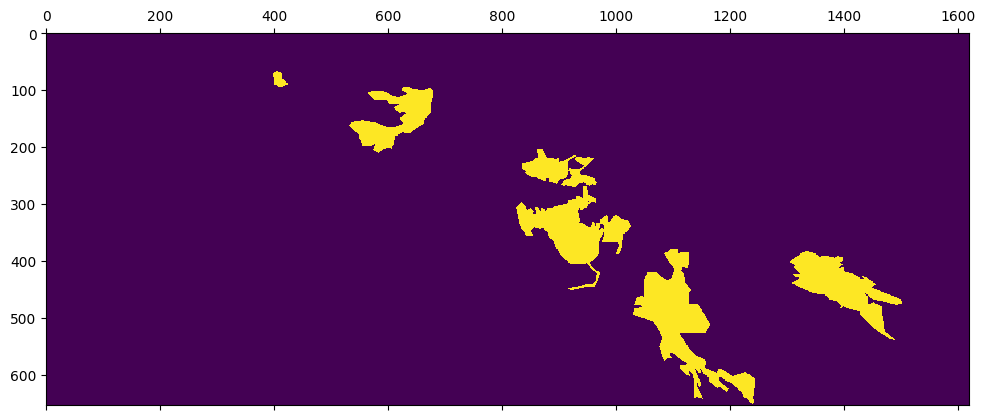

In [10]:
plt.matshow(label_arr)